In [1]:
#libraries 
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
from scipy.stats import skew
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate
%matplotlib inline

In [2]:
#import the dataset and describe
data = pd.read_csv('yellow_tripdata_2017-06.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-06-08 07:52:31,2017-06-08 08:01:32,6,1.03,1,N,161,140,1,7.5,1.0,0.5,1.86,0.0,0.3,11.16
1,2,2017-06-08 08:08:18,2017-06-08 08:14:00,6,1.03,1,N,162,233,1,6.0,1.0,0.5,2.34,0.0,0.3,10.14
2,2,2017-06-08 08:16:49,2017-06-08 15:43:22,6,5.63,1,N,137,41,2,21.5,1.0,0.5,0.00,0.0,0.3,23.30
3,2,2017-06-29 15:52:35,2017-06-29 16:03:27,6,1.43,1,N,142,48,1,8.5,1.0,0.5,0.88,0.0,0.3,11.18
4,1,2017-06-01 00:00:00,2017-06-01 00:03:43,1,0.60,1,N,140,141,1,4.5,0.5,0.5,2.00,0.0,0.3,7.80


# Distribution of the trips

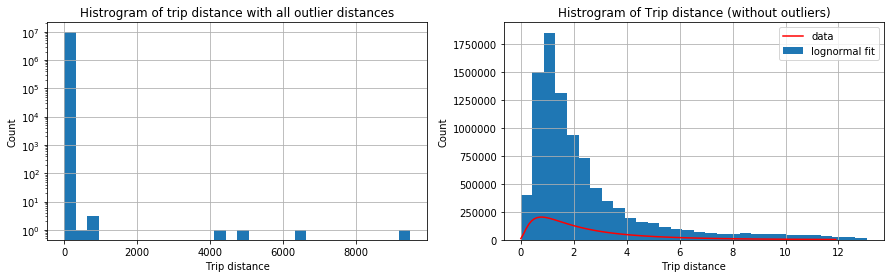

In [3]:
fig, ax = plt.subplots(1,2,figsize =(15,4))
#histrogram of trip distance
data.trip_distance.hist(bins=30,ax=ax[0])
ax[0].set_xlabel('Trip distance')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histrogram of trip distance with all outlier distances')
#creating a vector value to find all the trip distance 2 standard deviation away 
#these values which are away from the median are outliers in our case.
v= data.trip_distance
v[~((v-v.median()).abs()>2*v.std())].hist(bins=30,ax=ax[1])
ax[1].set_xlabel('Trip distance')
ax[1].set_ylabel('Count')
ax[1].set_title('Histrogram of Trip distance (without outliers)')
#applying a lognormal fit to scale the values 
scatter,loc,mean = lognorm.fit(data.trip_distance.values,scale=data.trip_distance.mean(),loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,12,.1),scatter,loc,mean)
ax[1].plot(np.arange(0,12,.1),600000*pdf_fitted,'r')
ax[1].legend(['data','lognormal fit'])
plt.show()

# Peak Hours of Commute in a day in the Month of June 2017

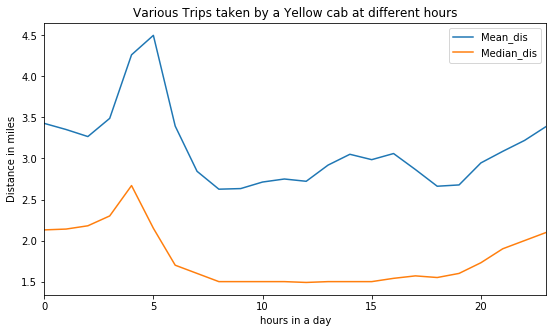

Distance travled by hour of the day
  Hour    Mean_dis    Median_dis
------  ----------  ------------
     0     3.42735          2.13
     1     3.35278          2.14
     2     3.26681          2.18
     3     3.48834          2.3
     4     4.26238          2.67
     5     4.49936          2.15
     6     3.3943           1.7
     7     2.84361          1.6
     8     2.62577          1.5
     9     2.63322          1.5
    10     2.71292          1.5
    11     2.74982          1.5
    12     2.72201          1.49
    13     2.91908          1.5
    14     3.05088          1.5
    15     2.98544          1.5
    16     3.05996          1.54
    17     2.86533          1.57
    18     2.66175          1.55
    19     2.6777           1.6
    20     2.94579          1.73
    21     3.08658          1.9
    22     3.21975          2
    23     3.39114          2.1


In [4]:
#convert the values of trip data pick up and drop off time to hours and create new columns
data['pickup_date'] = data.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['dropoff_date'] = data.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

#create hours from the pick up date time values
data['Pickup_hr'] = data.pickup_date.apply(lambda x:x.hour)
#Trip distance based on the pickup hours.

fig,ax = plt.subplots(1,1,figsize=(9,5))
triptable = data.pivot_table(index='Pickup_hr', values = 'trip_distance', aggfunc=('mean','median')).reset_index()
triptable.columns= ['Hour','Mean_dis','Median_dis']
triptable[['Mean_dis','Median_dis']].plot(ax=ax)
plt.ylabel('Distance in miles')
plt.xlabel('hours in a day')
plt.title('Various Trips taken by a Yellow cab at different hours')
plt.xlim(0,23)
plt.show()
print('Distance travled by hour of the day')
print(tabulate(triptable.values.tolist(),['Hour','Mean_dis','Median_dis']))

In [5]:
#let find out the average trips from or to the airport 
#from the dictionary lookup table we know the  rate code id of value of 1 is standard 2 is JFK and 3 Newark. 
#lets find the number of from the airpoprts. 
airport_trips = data[(data.RatecodeID ==2) | (data.RatecodeID==3)]
shape1 = airport_trips.shape[0]
print("Shape of the airport trips: ",shape1)
print("Average Fare of trips calculated by the taximater: $",airport_trips.fare_amount.mean())
print("Average Total: $",airport_trips.total_amount.mean())

Shape of the airport trips:  243347
Average Fare of trips calculated by the taximater: $ 53.20434050964261
Average Total: $ 67.40676881161467


In [6]:
data['PULocationID'].value_counts().head()

237    379701
161    358983
236    343355
162    331577
186    328511
Name: PULocationID, dtype: int64

In [7]:
data['DOLocationID'].value_counts().head()

161    364226
236    350744
237    332690
170    310935
230    298762
Name: DOLocationID, dtype: int64

In [8]:
data1 = pd.read_csv('taxi+_zone_lookup.csv')

In [9]:
data1.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [10]:
data1[(data1.LocationID ==161) | (data1.LocationID == 236)|(data1.LocationID==237)|(data1.LocationID==170)|(data1.LocationID== 230)|(data1.LocationID==162)|(data1.LocationID==186)]

,LocationID,Borough,Zone,service_zone
160,161,Manhattan,Midtown Center,Yellow Zone
161,162,Manhattan,Midtown East,Yellow Zone
169,170,Manhattan,Murray Hill,Yellow Zone
185,186,Manhattan,Penn Station/Madison Sq West,Yellow Zone
229,230,Manhattan,Times Sq/Theatre District,Yellow Zone
235,236,Manhattan,Upper East Side North,Yellow Zone
236,237,Manhattan,Upper East Side South,Yellow Zone


In [11]:
#short trips with tips more than 50
data[(data.trip_distance<=10) & (data.tip_amount >= 50)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_date,dropoff_date,Pickup_hr
47597,1,2017-06-09 22:54:29,2017-06-09 22:54:31,1,1.90,1,N,265,265,1,2.50,0.5,0.5,51.80,0.0,0.3,55.60,2017-06-09 22:54:29,2017-06-09 22:54:31,22
56054,1,2017-06-09 23:51:29,2017-06-09 23:51:35,1,2.60,1,N,265,265,1,2.50,0.5,0.5,94.00,0.0,0.3,97.80,2017-06-09 23:51:29,2017-06-09 23:51:35,23
64800,1,2017-06-10 00:50:12,2017-06-10 00:50:15,1,8.60,1,N,132,132,1,2.50,0.5,0.5,50.00,0.0,0.3,53.80,2017-06-10 00:50:12,2017-06-10 00:50:15,0
84282,1,2017-06-10 04:04:55,2017-06-10 04:12:15,1,0.60,1,N,230,164,1,6.50,0.5,0.5,100.00,0.0,0.3,107.80,2017-06-10 04:04:55,2017-06-10 04:12:15,4
84846,1,2017-06-10 04:14:07,2017-06-10 04:38:18,3,7.30,1,N,88,238,1,25.00,0.5,0.5,60.00,0.0,0.3,86.30,2017-06-10 04:14:07,2017-06-10 04:38:18,4
87157,1,2017-06-10 05:19:20,2017-06-10 05:19:56,1,0.00,5,N,132,132,1,0.00,0.0,0.0,62.50,0.0,0.3,62.80,2017-06-10 05:19:20,2017-06-10 05:19:56,5
102402,1,2017-06-10 09:52:42,2017-06-10 10:16:25,3,7.60,5,N,231,265,1,0.00,0.0,0.0,80.00,10.5,0.3,90.80,2017-06-10 09:52:42,2017-06-10 10:16:25,9
123872,1,2017-06-10 12:54:05,2017-06-10 12:54:24,1,0.00,1,N,265,265,1,2.50,0.0,0.5,76.70,0.0,0.3,80.00,2017-06-10 12:54:05,2017-06-10 12:54:24,12
171762,1,2017-06-10 17:53:47,2017-06-10 17:54:05,1,0.00,1,N,100,100,1,2.50,0.0,0.5,55.00,0.0,0.3,58.30,2017-06-10 17:53:47,2017-06-10 17:54:05,17
175746,1,2017-06-10 18:22:36,2017-06-10 18:53:31,1,4.70,5,N,100,265,1,0.00,0.0,0.0,60.00,12.5,0.3,72.80,2017-06-10 18:22:36,2017-06-10 18:53:31,18


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShell

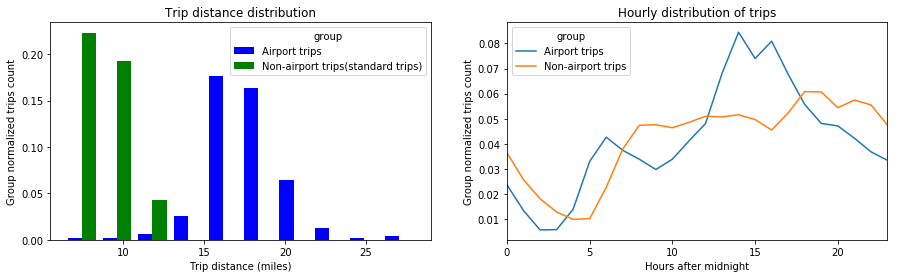

In [12]:
# create a vector to contain Trip Distance for
v2 = airport_trips.trip_distance # airport trips
v3 = data.loc[~data.index.isin(v2.index),'trip_distance'] # non-airport trips

# remove outliers: more than 2 sd away
v2 = v2[~((v2-v2.median()).abs()>2*v2.std())]
v3 = v3[~((v3-v3.median()).abs()>2*v3.std())] 

# define bins boundaries
bins = np.histogram(v2,normed=True)[1]
h2 = np.histogram(v2,bins=bins,normed=True)
h3 = np.histogram(v3,bins=bins,normed=True)
# First, convert pickup and drop off datetime variable in their specific righ format
data['pickup_date'] = data.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['dropoff_date'] = data.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

# Second, create a variable for pickup hours
data['Pickup_hr'] = data.pickup_date.apply(lambda x:x.hour)


# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,2,figsize = (15,4))
w = .4*(bins[1]-bins[0])
ax[0].bar(bins[:-1],h2[0],alpha=1,width=w,color='b')
ax[0].bar(bins[:-1]+w,h3[0],alpha=1,width=w,color='g')
ax[0].legend(['Airport trips','Non-airport trips(standard trips)'],loc='best',title='group')
ax[0].set_xlabel('Trip distance (miles)')
ax[0].set_ylabel('Group normalized trips count')
ax[0].set_title('Trip distance distribution')
#ax[0].set_yscale('log')

# plot hourly distribution
airport_trips.Pickup_hr.value_counts(normalize=True).sort_index().plot(ax=ax[1])
data.loc[~data.index.isin(v2.index),'Pickup_hr'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
ax[1].set_xlabel('Hours after midnight')
ax[1].set_ylabel('Group normalized trips count')
ax[1].set_title('Hourly distribution of trips')
ax[1].legend(['Airport trips','Non-airport trips'],loc='best',title='group')

plt.show()
